Parachute Surface Area (input): 4.00 ft^2
Drone Weight (input): 2.00 lbs
Nominal Diameter: 1.13 ft
Sea Level Descent Rate: 17.98 ft/s
Impact Energy: 13.62 J
Max Speed: 18.03 ft/s
Max Absolute Acceleration: 32.20 ft/s
Final Speed At Impact: 17.98 ft/s


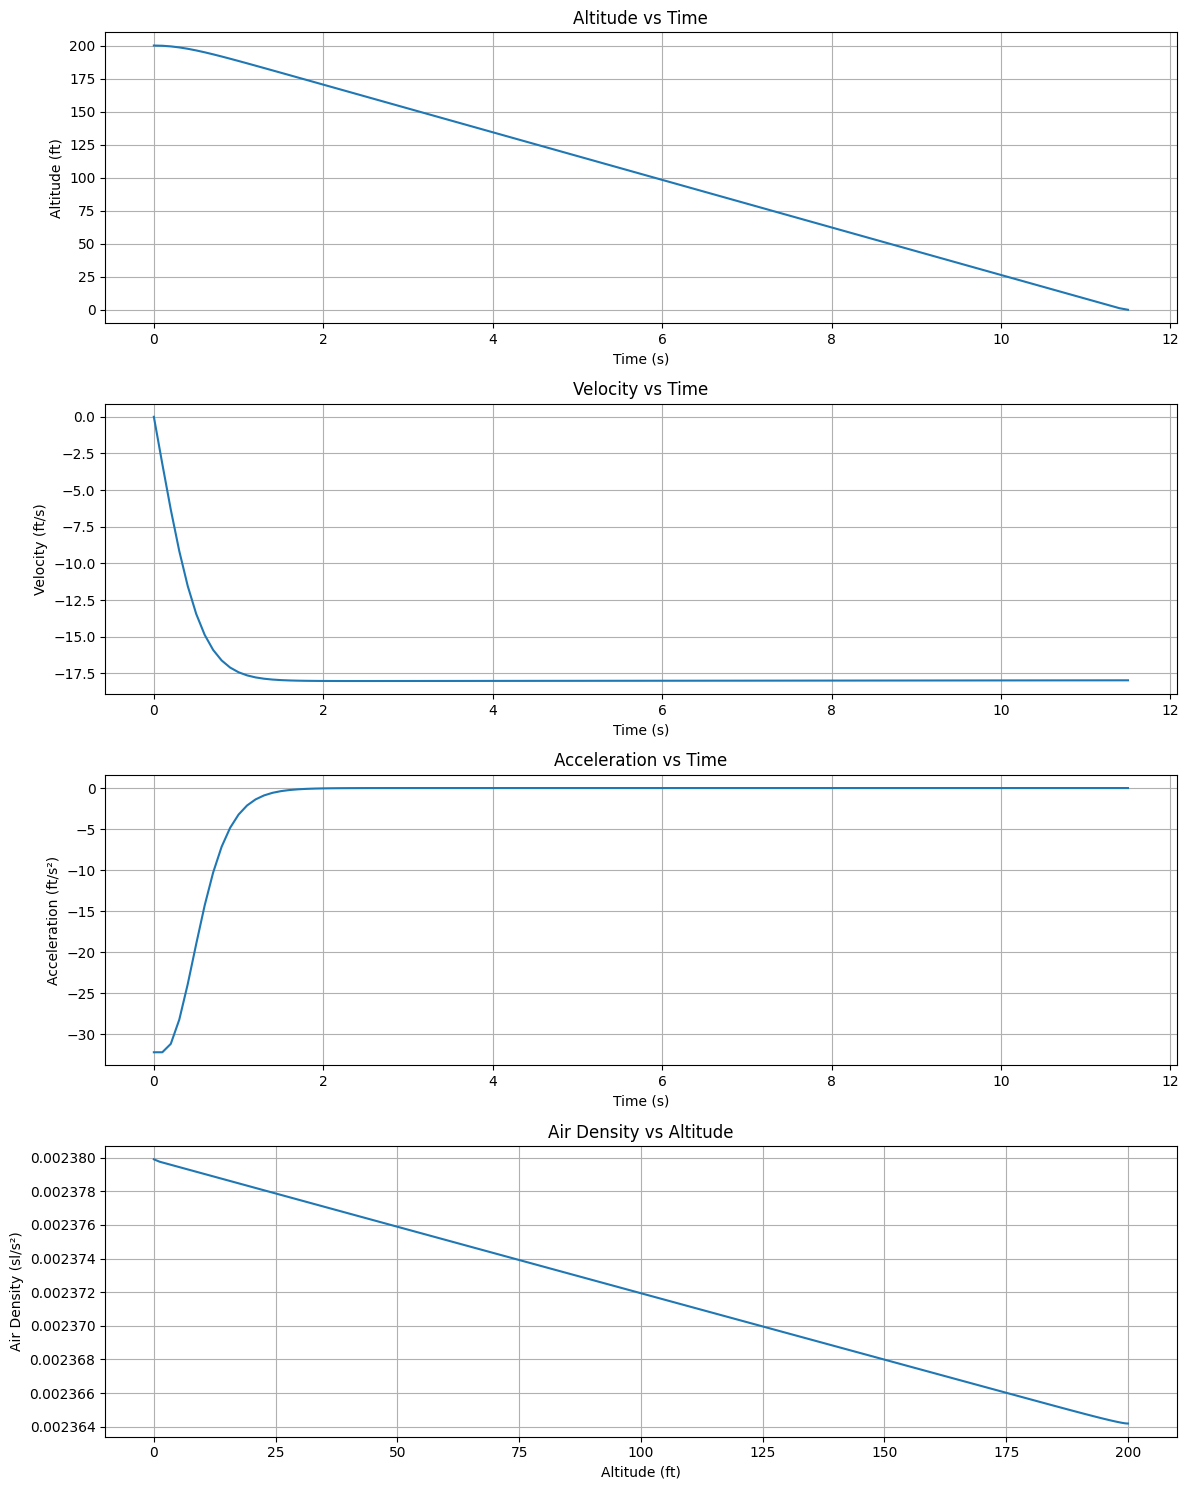

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Callable

@dataclass
class ParachuteParameters:
    """Class to hold parachute design parameters"""
    So: float  # Total canopy surface area (ft² or m²)
    Wt: float  # Total weight (lbs or N)
    Cdo: float  # Drag coefficient
    n: float   # Dimensionless fill constant
    
class ParachuteCalculator:
    """Class to perform parachute design calculations"""
    
    def __init__(self, params: ParachuteParameters):
        self.params = params
        # Standard sea level air density (slugs/ft³ or kg/m³)
        self.rho_sea_level = 0.00238  # slugs/ft³ (1.225 kg/m³) - at sea level and at 58°F (15°C)
        self.g = 32.2  # ft/s² (9.81 m/s²)
        
    def calculate_nominal_diameter(self) -> float:
        """
        Calculate nominal diameter of the parachute (Do)
        Returns diameter in same units as sqrt(So)
        """
        return np.sqrt((self.params.So / np.pi))
    
    def calculate_descent_rate_sea_level(self) -> float:
        """
        Calculate rate of descent at sea level (vco)
        Returns velocity in ft/s or m/s depending on input units
        """
        Do = self.calculate_nominal_diameter()
        vco = np.sqrt((2 * self.params.Wt) / 
                     (self.params.So * self.params.Cdo * self.rho_sea_level))
        return vco
    
    def calculate_descent_rate_altitude(self, rho_altitude: float) -> float:
        """
        Calculate rate of descent at a specific altitude
        
        Args:
            rho_altitude: Air density at specific altitude (slugs/ft³ or kg/m³)
        
        Returns:
            Velocity in ft/s or m/s depending on input units
        """
        vco = self.calculate_descent_rate_sea_level()
        return vco * np.sqrt( self.rho_sea_level / rho_altitude)
    
    def calculate_filling_distance(self, Dp: float) -> float:
        """
        Calculate filling distance of the parachute canopy
        
        Args:
            Dp: Parachute diameter at full inflation (ft or m)
            
        Returns:
            Filling distance in same units as Dp
        """
        return self.params.n * Dp
    
    def calculate_acceleration(self, velocity: float,
                             rho_altitude: float) -> float:
        """
        Calculate acceleration at a given velocity and altitude
        
        Args:
            velocity: Current velocity (ft/s or m/s)
            altitude: Current altitude (ft or m)
            rho_altitude: Air density at current altitude
            
        Returns:
            Acceleration in ft/s² or m/s²
        """
        # Force of gravity
        Fg = self.params.Wt
        
        # Drag force (F = 0.5 * rho * v^2 * Cd * A)
        Fd = 0.5 * rho_altitude * velocity**2 * self.params.Cdo * self.params.So
        
        # Net force
        Fnet = Fd - Fg
        
        # Acceleration (F = ma)
        return (Fnet / (self.params.Wt / self.g))
    
    
    def simulate_descent(self, initial_altitude: float, 
                        dt: float = 0.1, 
                        rho_altitude_func: Callable[[float], float] = None) -> Tuple[np.ndarray, ...]:
        """
        Simulate complete descent from initial altitude to ground
        
        Args:
            initial_altitude: Starting altitude (ft or m)
            dt: Time step for simulation (s)
            rho_altitude_func: Function to calculate air density at given altitude
            
        Returns:
            Tuple of (time_points, altitudes, velocities, accelerations)
        """
        if rho_altitude_func is None:
            rho_altitude_func = lambda h: self.rho_sea_level * np.exp(-h/30000)
        
        # Initialize arrays
        time_points = [0]
        altitudes = [initial_altitude]
        velocities = [0]  # Start from rest
        accelerations = [-self.g]  # Start with gravitational acceleration
        
        # Prepare to store air density values for plotting
        rho_values = [rho_altitude_func(initial_altitude)]

        # Run simulation until ground is reached
        while altitudes[-1] > 0:

            # Current state
            h = altitudes[-1]
            v = velocities[-1]
            t = time_points[-1]

            # Calculate current acceleration
            rho = rho_altitude_func(h)
            rho_values.append(rho)
            a = self.calculate_acceleration(v, rho)
            # Update state using simple numerical integration
            v_new = v + a * dt
            h_new = h + v * dt + 0.5 * a * dt**2
            
            # Store new state
            time_points.append(t + dt)
            altitudes.append(max(0, h_new))  # Prevent negative altitudes
            velocities.append(v_new)
            accelerations.append(a)

        
        return (np.array(time_points), np.array(altitudes), 
                np.array(velocities), np.array(accelerations), np.array(rho_values))
    
    def plot_descent_simulation(self, initial_altitude: float, 
                              dt: float = 0.1,
                              rho_altitude_func: Callable[[float], float] = None) -> None:
        """
        Plot complete descent simulation results
        
        Args:
            initial_altitude: Starting altitude (ft or m)
            dt: Time step for simulation (s)
            rho_altitude_func: Function to calculate air density at given altitude
        """
        # Run simulation
        times, altitudes, velocities, accelerations, rho_values = self.simulate_descent(
            initial_altitude, dt, rho_altitude_func)
        
        print(f"Max Speed: {max(abs(velocities)):.2f} ft/s")
        print(f"Max Absolute Acceleration: {max(abs(accelerations)):.2f} ft/s")
        print(f"Final Speed At Impact: {abs(velocities[-1]):.2f} ft/s")
        
        # Create subplots
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 15))
        
        # Plot position vs time
        ax1.plot(times, altitudes)
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Altitude (ft)')
        ax1.set_title('Altitude vs Time')
        ax1.grid(True)
        
        # Plot velocity vs time
        ax2.plot(times, velocities)
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Velocity (ft/s)')
        ax2.set_title('Velocity vs Time')
        ax2.grid(True)
        
        # Plot acceleration vs time
        ax3.plot(times, accelerations)
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Acceleration (ft/s²)')
        ax3.set_title('Acceleration vs Time')
        ax3.grid(True)

        # Plot Air Density vs Altitude
        ax4.plot(altitudes, rho_values)
        ax4.set_xlabel('Altitude (ft)')
        ax4.set_ylabel('Air Density (sl/s²)')
        ax4.set_title('Air Density vs Altitude')
        ax4.grid(True)
        
        plt.tight_layout()
        plt.show()

# Example usage
def example_calculation():
    # Example parameters (using imperial units)
    params = ParachuteParameters(
        So=4,    # ft²
        Wt=2,    # lbs (Matrice 3000 with single gimbal and 2 batteries is 6.47 kg)
        Cdo=1.3,   # typical value for round parachutes
        n=3        # typical value for round parachutes
    )
    
    calculator = ParachuteCalculator(params)
    
    # Constants for unit conversion
    FT_TO_M = 0.3048  # feet to meters
    LB_TO_KG = 0.453592  # pounds to kilograms

    # Calculate parameters
    Do = calculator.calculate_nominal_diameter()
    vco = calculator.calculate_descent_rate_sea_level()  # descent rate in ft/s
    vco_mps = vco * FT_TO_M  # convert ft/s to m/s
    mass_kg = params.Wt * LB_TO_KG  # convert weight in lbs to mass in kg

    # Calculate impact energy in joules
    impact_energy_joules = 0.5 * mass_kg * vco_mps**2

    # Print results
    print(f"Parachute Surface Area (input): {params.So:.2f} ft^2")
    print(f"Drone Weight (input): {params.Wt:.2f} lbs")
    print(f"Nominal Diameter: {Do:.2f} ft")
    print(f"Sea Level Descent Rate: {vco:.2f} ft/s")
    print(f"Impact Energy: {impact_energy_joules:.2f} J")  # output in joules
    # Run and plot complete descent simulation
    calculator.plot_descent_simulation(initial_altitude=200)  # 5000 ft initial altitude

if __name__ == "__main__":
    example_calculation()